# 1. Load data from CSV files

Subsurface Hackathon 2017, Paris.

*Joseph Barraud and Martin Bentley*

---
This notebook describes the work that was conducted by our team during the [Subsurface Hackathon in Paris](https://agilescientific.com/paris/) (10-11 June 2017). 

Our team (*Water Underground*) got their hands on some data from the Geological Survey of the Netherlands. A large set of files were downloaded using their web interface available at this [address](https://www.dinoloket.nl/en). 

The downloaded files are available in the `data` folder that is located in this GitHub repository. There are two types of files:
- the .txt files in `/data/Groundwater-Composition` provide chemical compositions of groungwater at well locations
- the .csv files in `/data/Groundwater-Levels` provide the depth of the water table in the well

This notebook presents a few methods for extracting the data from the csv files and to start some exploratory work.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

### Options

In [2]:
# pandas options
pd.options.display.max_rows = 6

## Test with one file

Let's start by reading one of the csv files as a text file. We can display the first 15 lines to see what's in it.

In [3]:
inFile = r'..\data\Groundwater-Levels\B24F0047001_0.csv'
with open (inFile) as f:
    lines = f.readlines()

for line in lines[:15]:
    print(line,end='')

Titel: 
Gebruikersnaam: 
Periode aangevraagd: 01/01/1800-08/06/2017
Datum: 08/06/2017
Referentie: Maaiveld (MV)


LOCATIE,FILTERNUMMER,EXTERNE AANDUIDING,X-COORDINAAT,Y-COORDINAAT,MAAIVELD NAP,GESCHAT,MEETPUNT NAP,BOVENKANT FILTER,ONDERKANT FILTER,START DATUM,EIND DATUM
B24F0047,001,24FP0047,99920,489815,780,,779,-200,-300,1970/04/28,2015/09/14

LOCATIE,FILTERNUMMER,PEIL DATUM TIJD,STAND (MV),BIJZONDERHEID
B24F0047,001,1970/04/28 00:00:00,585,
B24F0047,001,1970/05/14 00:00:00,589,
B24F0047,001,1970/05/28 00:00:00,584,
B24F0047,001,1970/06/15 00:00:00,596,


We can see that it is not a standard csv file as it has got a first paragraph with some information, then two sets of data:
- the metadata about the well (with, crucially, the x and y coordinates)
- the depth measurements

Let's start with the second block of data. By skipping the first 10 rows, we can tell pandas to import only the depth information in a dataframe. At the same time, we can also choose the option to read the third column as a date and to make it the index of our new dataframe.

In [4]:
df = pd.read_csv(inFile, skiprows=10, parse_dates=[2], index_col =2)

In [5]:
df

,LOCATIE,FILTERNUMMER,STAND (MV),BIJZONDERHEID
PEIL DATUM TIJD,,,,
1970-04-28 00:00:00,B24F0047,1,585,NaN
1970-05-14 00:00:00,B24F0047,1,589,NaN
1970-05-28 00:00:00,B24F0047,1,584,NaN
...,...,...,...,...
2013-06-27 16:08:00,B24F0047,1,485,NaN
2014-10-01 14:02:00,B24F0047,1,506,NaN
2015-09-10 12:02:00,B24F0047,1,535,NaN


So now everything is in place to create a plot of the evolution of the water depth (**stand (MV)**) versus time.

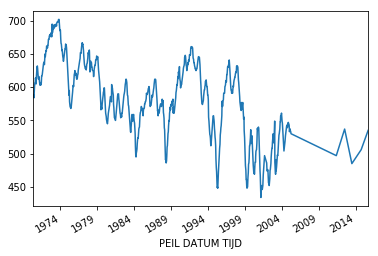

In [6]:
df['STAND (MV)'].plot()

## Load all the files in a folder

We should now try to load several files together and add them to a single dataframe.

Looking at the available data, there are actually two types of files in our directory:
- files with a name finishing with '_0': one type of water depth (relative to ground level (MV))
- files with a name finishing with '_1': three types of depth measurements

The second type is the one of interest because it gives us access to the water depth relative to the Amsterdam Ordnance Datum (or NAP, https://en.wikipedia.org/wiki/Amsterdam_Ordnance_Datum). If we want to compare several wells with each other, we obviously need a common reference level, so that's the one to choose.

These files (like 'B24F0005001_1.csv' for example) have a slightly different format from the one we have previously looked at: the header and the metadata take more spaces at the beginning of the file. By examining several files, we also realised that the length of the header is actually variable. So we wrote a function `read_header` that would extract that part of the file first. 

In [7]:
def read_header(file):
    '''Read the first lines of the file and identify the position of data blocks by finding the word "locatie".
    Return the line number of the block with metadata (metarow) and the line number of the block with data (datarow).'''
    i=0
    loc=0
    with open(file) as f:
        for line in f:
            if line[:7].lower()=='locatie':
                loc = loc + 1
                if loc==1:
                    metarow = i
                if loc==2:
                    datarow = i
                    break
            i=i+1
    return metarow,datarow

This second function `get_xy` is used to extract the x and y coordinates of the well from the metadata block.

In [8]:
def get_xy(file,metarow):
    with open(file) as f:
        lines = f.readlines()
    line = lines[metarow+1].split(',')
    return [int(x) for x in line[3:5]]

Now we need a loop that is going to read through all the files in a given folder and extract the useful data. The data is converted into a pandas dataframe. Finally all the dataframes are merged together.

A try/except statement was added to catch the few import errors. There are errors when the data block contains the wrong number of columns.

In [9]:
inFolder = r'..\data\Groundwater-Levels'
df_list = []
for file in os.listdir(inFolder):
    
    wellFile,ext = os.path.splitext(file)
    if wellFile[-2:] == '_1':
        print(file,end=', ')
        try:
            # read header 
            metarow,datarow = read_header(os.path.join(inFolder, file))
            # find coordinates of the well
            (x,y) = get_xy(os.path.join(inFolder, file), metarow)
            # read the data
            df = pd.read_csv(os.path.join(inFolder, file), skiprows=datarow, 
                             index_col=False, parse_dates=[2],dayfirst=True)
            # add the coordinates 
            df['x'] = x
            df['y'] = y
            # add the dataframe to the list
            df_list.append(df)
            print('ok')                
        except:
            print('error')

# merge all the dataframes
all_dfs = pd.concat(df_list)

B24F0005001_1.csv, ok
B24F0005002_1.csv, ok
B24F0028001_1.csv, ok
B24F0028002_1.csv, ok
B24F0029001_1.csv, ok
B24F0030001_1.csv, ok
B24F0043001_1.csv, ok
B24F0043002_1.csv, ok
B24F0045001_1.csv, ok
B24F0045002_1.csv, ok
B24F0045003_1.csv, ok
B24F0047001_1.csv, ok
B24F0047002_1.csv, ok
B24F0049001_1.csv, ok
B24F0065001_1.csv, ok
B24F0065002_1.csv, ok
B24F0069001_1.csv, ok
B24F0069002_1.csv, ok
B24F0069003_1.csv, ok
B24F0069004_1.csv, ok
B24F0069005_1.csv, ok
B24F0069006_1.csv, ok
B24F0069007_1.csv, ok
B24F0086001_1.csv, ok
B24F0088001_1.csv, ok
B24F0088002_1.csv, ok
B24F0089001_1.csv, ok
B24F0089002_1.csv, ok
B24F0090001_1.csv, ok
B24F0091001_1.csv, ok
B24F0098001_1.csv, ok
B24F0099001_1.csv, ok
B24F0100001_1.csv, ok
B24F0101001_1.csv, ok
B24F0102001_1.csv, ok
B24F0103001_1.csv, ok
B24F0104001_1.csv, ok
B24F0105001_1.csv, ok
B24F0106001_1.csv, ok
B24F0107001_1.csv, ok
B24F0108001_1.csv, ok
B24F0109001_1.csv, ok
B24F0110001_1.csv, ok
B24F0111001_1.csv, ok
B24F0112001_1.csv, ok
B24F011300

B25A1673001_1.csv, ok
B25A1674001_1.csv, ok
B25A1675001_1.csv, ok
B25A1676001_1.csv, ok
B25A1677001_1.csv, ok
B25A1678001_1.csv, ok
B25A1679001_1.csv, ok
B25A1680001_1.csv, ok
B25A1681001_1.csv, ok
B25A1682001_1.csv, ok
B25A1683001_1.csv, ok
B25A1684001_1.csv, ok
B25A1685001_1.csv, ok
B25A1685002_1.csv, ok
B25A1685003_1.csv, ok
B25A1686001_1.csv, ok
B25A1686002_1.csv, ok
B25A1687001_1.csv, ok
B25A1687002_1.csv, ok
B25A1688001_1.csv, ok
B25A1689001_1.csv, ok
B25A1689002_1.csv, ok
B25A1690001_1.csv, ok
B25A1692001_1.csv, ok
B25A1693001_1.csv, ok
B25A2877001_1.csv, ok
B25A3862001_1.csv, ok
B25A3863001_1.csv, ok
B25A3864001_1.csv, ok
B25A3865001_1.csv, ok
B25A3866001_1.csv, ok
B25A3867001_1.csv, ok
B25A3868001_1.csv, ok
B25A3869001_1.csv, ok
B25A3870001_1.csv, ok
B25A3871001_1.csv, ok
B25A3872001_1.csv, ok
B25A3873001_1.csv, ok
B25A3874001_1.csv, ok
B25A3875001_1.csv, ok
B25A3876001_1.csv, ok
B25A3877001_1.csv, ok
B25A3878001_1.csv, ok
B25A3879001_1.csv, ok
B25A3880001_1.csv, ok
B25A388100

B25E0171001_1.csv, ok
B25E0171002_1.csv, ok
B25E0172001_1.csv, error
B25E0172002_1.csv, error
B25E0172003_1.csv, error
B25E0174001_1.csv, error
B25E0174002_1.csv, error
B25E0174003_1.csv, error
B25E0175001_1.csv, error
B25E0175002_1.csv, error
B25E0176001_1.csv, error
B25E0176002_1.csv, error
B25E0184001_1.csv, error
B25E0184002_1.csv, error
B25E0184003_1.csv, error
B25E0185001_1.csv, ok
B25E0185002_1.csv, ok
B25E0185003_1.csv, ok
B25E0186001_1.csv, ok
B25E0186002_1.csv, ok
B25E0187001_1.csv, ok
B25E0187002_1.csv, ok
B25E0188001_1.csv, error
B25E0188002_1.csv, error
B25E0250001_1.csv, ok
B25E0274001_1.csv, ok
B25E0274002_1.csv, ok
B25E0275001_1.csv, ok
B25E0275002_1.csv, ok
B25E0276001_1.csv, ok
B25E0276002_1.csv, ok
B25E0276003_1.csv, ok
B25E0277001_1.csv, ok
B25E0277002_1.csv, ok
B25E0277003_1.csv, ok
B25E0320001_1.csv, ok
B25E0320002_1.csv, ok
B25E0340001_1.csv, ok
B25E0341001_1.csv, ok
B25E0342001_1.csv, ok
B25E0344001_1.csv, ok
B25E0344002_1.csv, ok
B25E0344003_1.csv, ok
B25E03440

Let's look at the result. But first we can define a new index (a multiindex) that combines well number, "filternummer" (*filter number*) and the date of the observation.

As far as we can tell, the filter number indicates which filter (or *screen*) has been sampled in the monitoring well.

In [10]:
# set index
all_dfs.set_index(['Locatie','Filternummer','Peildatum'],inplace=True)

In [11]:
all_dfs

Stand (cm t.o.v. MP)  Stand (cm t.o.v. MV)  \
Locatie  Filternummer Peildatum                                                
B24F0005 1            1956-01-17                 343.0                 296.0   
                      1956-03-21                 324.0                 277.0   
                      1956-04-18                 333.0                 286.0   
...                                                ...                   ...   
B25G0519 3            1996-10-21                 370.0                 387.0   
                      1996-11-14                 366.0                 383.0   
                      1996-11-19                 360.0                 377.0   

                                  Stand (cm t.o.v. NAP) Bijzonderheid  \
Locatie  Filternummer Peildatum                                         
B24F0005 1            1956-01-17                  347.0           NaN   
                      1956-03-21                  366.0           NaN   
                      1956-04-18                  357.0           NaN   
...                                                 ...           ...   
B25G0519 3            1996-10-21                 -317.0           NaN   
                      1996-11-14                 -313.0           NaN   
                      1996-11-19                 -307.0           NaN   

                                 Opmerking  Unnamed: 8  Unnamed: 9  \
Locatie  Filternummer Peildatum                                      
B24F0005 1            1956-01-17       NaN         NaN         NaN   
                      1956-03-21       NaN         NaN         NaN   
                      1956-04-18       NaN         NaN         NaN   
...                                    ...         ...         ...   
B25G0519 3            1996-10-21       NaN         NaN         NaN   
                      1996-11-14       NaN         NaN         NaN   
                      1996-11-19       NaN         NaN         NaN   

                                  Unnamed: 10       x       y  
Locatie  Filternummer Peildatum                                
B24F0005 1            1956-01-17          NaN   99680  493440  
                      1956-03-21          NaN   99680  493440  
                      1956-04-18          NaN   99680  493440  
...                                       ...     ...     ...  
B25G0519 3            1996-10-21          NaN  120516  485658  
                      1996-11-14          NaN  120516  485658  
                      1996-11-19          NaN  120516  485658  

[613864 rows x 10 columns]

Next, we need to drop the empty columns and select only the ones we are interested in.

In [12]:
all_depths = all_dfs[['Stand (cm t.o.v. NAP)','x','y']]

Finally, let's rename the columns and the index names.

In [13]:
all_depths = all_depths.rename(columns={'Stand (cm t.o.v. NAP)':'depth'})
all_depths.index = all_depths.index.set_names(['well', 'screen', 'date'])

In [14]:
all_depths

depth       x       y
well     screen date                             
B24F0005 1      1956-01-17  347.0   99680  493440
                1956-03-21  366.0   99680  493440
                1956-04-18  357.0   99680  493440
...                           ...     ...     ...
B25G0519 3      1996-10-21 -317.0  120516  485658
                1996-11-14 -313.0  120516  485658
                1996-11-19 -307.0  120516  485658

[613864 rows x 3 columns]

## Indexing and slicing

The multiindex makes it easier to interrogate the database to get the requested information. Here are a few examples.

For a single well:

In [15]:
all_depths.loc['B25A0549']

depth       x       y
screen date                             
1      1958-05-28   -1.0  102370  489650
       1958-06-04   -8.0  102370  489650
       1958-06-13  -10.0  102370  489650
...                  ...     ...     ...
2      1988-01-14  -40.0  102370  489650
       1988-01-28  -38.0  102370  489650
       1988-02-14  -36.0  102370  489650

[1311 rows x 3 columns]

We can get the data for a particular screen number at this well location in this way:

In [16]:
all_depths.loc[('B25A0549', 2)]

,depth,x,y
date,,,
1958-05-28,-93.0,102370,489650
1958-06-04,-101.0,102370,489650
1958-06-13,-94.0,102370,489650
...,...,...,...
1988-01-14,-40.0,102370,489650
1988-01-28,-38.0,102370,489650
1988-02-14,-36.0,102370,489650


Note that we've lost the first two columns of the index (well and screen number). If you still want them, you can use:

In [17]:
all_depths.loc[('B25A0549', 2, slice(None)), :]

depth       x       y
well     screen date                             
B25A0549 2      1958-05-28  -93.0  102370  489650
                1958-06-04 -101.0  102370  489650
                1958-06-13  -94.0  102370  489650
...                           ...     ...     ...
                1988-01-14  -40.0  102370  489650
                1988-01-28  -38.0  102370  489650
                1988-02-14  -36.0  102370  489650

[644 rows x 3 columns]

Slicing with a date range is also possible:

In [18]:
all_depths.loc[('B25A1546', 1, slice('1975','1980')), :]

depth       x       y
well     screen date                             
B25A1546 1      1975-01-15  -52.0  104270  489030
                1975-01-28  -34.0  104270  489030
                1975-02-14  -46.0  104270  489030
...                           ...     ...     ...
                1980-11-28  -65.0  104270  489030
                1980-12-16  -62.0  104270  489030
                1980-12-24  -57.0  104270  489030

[98 rows x 3 columns]

## Exploratory statistics

In [19]:
# list the well numbers
well_list = all_dfs.index.get_level_values(0).unique()
len(well_list)

564

In [20]:
# some global stats
all_depths.describe().T

,count,mean,std,min,25%,50%,75%,max
depth,587911.0,-50.073033,211.878841,-1760.0,-205.0,-75.0,66.0,1078.0
x,613864.0,108384.983575,9370.586794,98170.0,101595.0,104660.0,114400.0,135950.0
y,613864.0,492218.387271,3772.036860,484368.0,489650.0,492400.0,495410.0,499205.0


One of the strengths of pandas is to offer numerous ways to aggregate the statistics per groups. For example, here is the average depth for each well and screen number.

In [21]:
# table with average depths. The use of ".style" allows me to display all the rows.
all_depths.mean(level=[0,1]).style

## Plotting

Plotting the data will be demonstrated in another notebook, so just to conclude this one, we can simply show the (x,y) locations of the wells with a scatter plot.

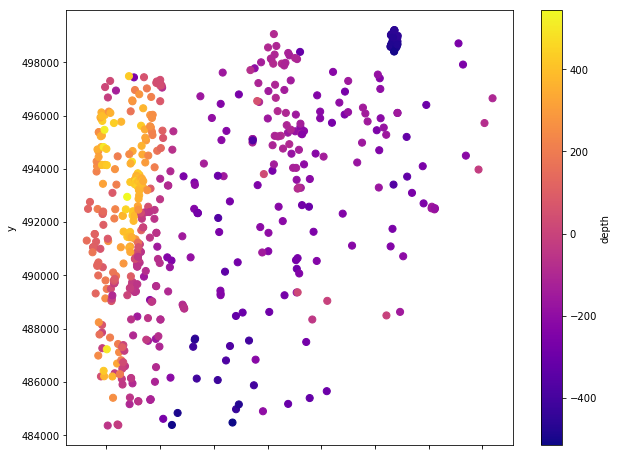

In [22]:
# plot well locations and color symbols according to the depth of screen number 1.
means = all_depths.loc[(slice(None),1),:].mean(level=[0,1])
means.plot.scatter(x='x',y='y',c='depth', cmap='plasma', s=50, figsize=(10,8))

## Save the results

In [23]:
# save dataframe as a pickled file (.gz compression requires pandas 0.20.0)
all_depths.to_pickle(os.path.join(inFolder, 'all_depths_v1.pkl.gz'))